Files already downloaded and verified
Starting Training on GPU with FP32 Tensor Core Optimization...

[1/10] [0/157] Loss_D: 1.4084 | Loss_G: 3.2596
[1/10] [50/157] Loss_D: 0.0497 | Loss_G: 11.6326
[1/10] [100/157] Loss_D: 0.2262 | Loss_G: 5.7864
[1/10] [150/157] Loss_D: 1.5297 | Loss_G: 6.2328
[2/10] [0/157] Loss_D: 0.7248 | Loss_G: 2.1419
[2/10] [50/157] Loss_D: 0.6955 | Loss_G: 3.5262
[2/10] [100/157] Loss_D: 0.9997 | Loss_G: 2.0852
[2/10] [150/157] Loss_D: 0.8885 | Loss_G: 1.3577
[3/10] [0/157] Loss_D: 0.7341 | Loss_G: 2.0314
[3/10] [50/157] Loss_D: 0.5737 | Loss_G: 2.8857
[3/10] [100/157] Loss_D: 1.9103 | Loss_G: 1.7987
[3/10] [150/157] Loss_D: 0.8438 | Loss_G: 4.2085
[4/10] [0/157] Loss_D: 0.7046 | Loss_G: 2.8814
[4/10] [50/157] Loss_D: 0.6570 | Loss_G: 4.4516
[4/10] [100/157] Loss_D: 1.0036 | Loss_G: 6.2318
[4/10] [150/157] Loss_D: 0.6264 | Loss_G: 2.6454
[5/10] [0/157] Loss_D: 0.3275 | Loss_G: 2.4041
[5/10] [50/157] Loss_D: 0.4860 | Loss_G: 4.6222
[5/10] [100/157] Loss_D: 0.479

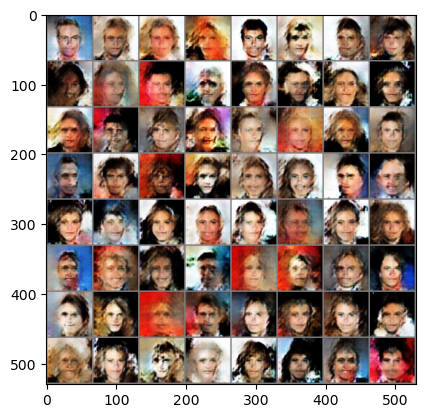

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np
import time

# Ensure GPU is used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Enable Tensor Core acceleration for FP32 (TF32 mode)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# Function to visualize generated images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

# Generator (Optimized for FP32 with Tensor Cores)
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Discriminator (Optimized for FP32 with Tensor Cores)
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
        )

    def forward(self, x):
        return self.main(x).view(-1)  # No Sigmoid; handled by BCEWithLogitsLoss

# Hyperparameters
nz = 100
ngf = 64
ndf = 64
nc = 3  # RGB images for CelebA
lr = 0.0002
beta1 = 0.5
batch_size = 64  
epochs = 10

# Create Generator and Discriminator
netG = Generator(nz, ngf, nc).to(device).to(memory_format=torch.channels_last)
netD = Discriminator(nc, ndf).to(device).to(memory_format=torch.channels_last)

# Loss function and optimizers
criterion = nn.BCEWithLogitsLoss()  # More stable for FP32
optimizerG = optim.AdamW(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.AdamW(netD.parameters(), lr=lr, betas=(beta1, 0.999))

# Data loading and preprocessing for CelebA
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Using CelebA dataset
dataset = torchvision.datasets.CelebA(root='./data', split='train', download=True, transform=transform)
indices = torch.randperm(len(dataset))[:10000]  # Optionally, select a subset of 10,000 samples for quicker training
dataset = Subset(dataset, indices)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Start Timing
start_time = time.time()

# Training loop
print("Starting Training on GPU with FP32 Tensor Core Optimization...\n")
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device, memory_format=torch.channels_last)

        batch_size_current = real_images.size(0)
        noise = torch.randn(batch_size_current, nz, 1, 1, device=device)

        # Train Discriminator
        netD.zero_grad()
        real_labels = torch.ones(batch_size_current, device=device)  # Real images = 1
        real_output = netD(real_images)
        real_loss = criterion(real_output, real_labels)

        fake_images = netG(noise)
        fake_labels = torch.zeros(batch_size_current, device=device)  # Fake images = 0
        fake_output = netD(fake_images.detach())
        fake_loss = criterion(fake_output, fake_labels)

        D_loss = real_loss + fake_loss
        D_loss.backward()
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        G_labels = torch.ones(batch_size_current, device=device)  # Fool Discriminator
        G_output = netD(fake_images)
        G_loss = criterion(G_output, G_labels)

        G_loss.backward()
        optimizerG.step()

        # Print progress
        if i % 50 == 0:
            print(f"[{epoch+1}/{epochs}] [{i}/{len(dataloader)}] Loss_D: {D_loss.item():.4f} | Loss_G: {G_loss.item():.4f}")

# End Timing
end_time = time.time()
print(f"\nTraining completed in {(end_time - start_time):.2f} seconds.")

# Generate images after training
noise = torch.randn(batch_size, nz, 1, 1, device=device)
fake_images = netG(noise).detach().cpu()

# Visualize the generated images
generated_grid = torchvision.utils.make_grid(fake_images[:64], nrow=8, padding=2)
imshow(generated_grid)

# Save trained models
torch.save(netG.state_dict(), "dcgan_generator_celeba_tf32.pth")
torch.save(netD.state_dict(), "dcgan_discriminator_celeba_tf32.pth")
